In [0]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2020-05-23 00:11:44--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  2.67MB/s    in 3m 8s   

2020-05-23 00:14:52 (1.27 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [0]:
!tar -xvf maps.tar.gz


maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/531.jpg
maps/train/532.jpg
maps/train/533.jpg
maps/train/534.jpg
maps/train/535.jpg
maps/train/536.jpg
maps/train/537.jpg
maps/train/538.jpg
maps/train/539.jpg
maps/train/54.jpg
maps/train/540.jpg
maps/train/541.jpg
maps/train/542.jpg
maps/train/543.jpg
maps/train/544.jpg
maps/train/545.jpg
maps/train/546.jpg
maps/train/547.jpg
maps/train/548.jpg
maps/train/549.jpg
maps/train/55.jpg
maps/train/550.jpg
maps/train/551.jpg
maps/train/552.jpg
maps/train/553.jpg
maps/train/554.jpg
maps/train/555.jpg
maps/train/556.jpg
maps/train/557.jpg
maps/train/558.jpg
ma

In [0]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [0]:
sample_img = load_img("maps/train/" + os.listdir("maps/train/")[0])
pix = (img_to_array(sample_img , dtype = "float32") - 127.5)/127.5

In [0]:
mkdir images

In [0]:
mkdir models

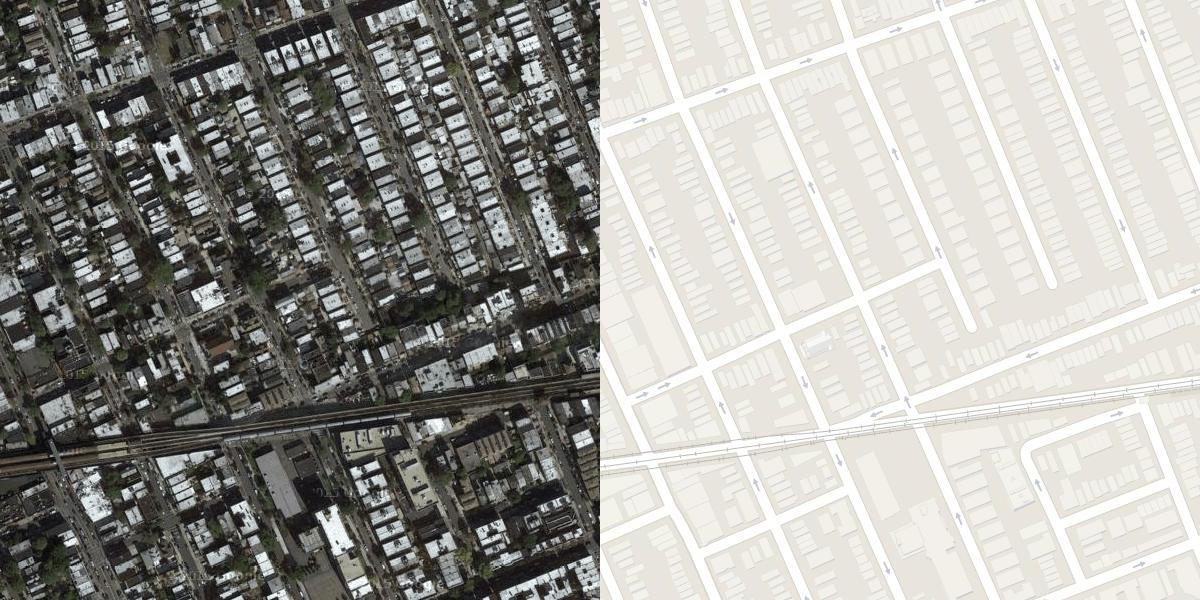

In [0]:
array_to_img(pix)

In [0]:
def load_imgs(dir):
  src_images, tar_images = [], []
  for filename in os.listdir(dir):
    img = load_img(dir + filename, target_size = (256,512,3))
    pixels = img_to_array(img)
    p1 = (pixels[:,:256] - 127.5) / 127.5
    src_images.append(p1)
    p2 = (pixels[:,256:] - 127.5) / 127.5
    tar_images.append(p2)
  return [np.asarray(src_images), np.asarray(tar_images)]
  


In [0]:
data = load_imgs("maps/train/")

In [0]:
from keras.initializers import RandomNormal
from keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, BatchNormalization, LeakyReLU, Activation, Input, Concatenate
from keras.models import Model
import keras

In [0]:
def discriminator(inp_shape = (256, 256,3)):

  in_src_img = Input(inp_shape)
  in_tar_img = Input(inp_shape)
  init = RandomNormal(0.02)
  merge = Concatenate()([in_src_img, in_tar_img])

  g = Conv2D(64, (4,4), strides = (2,2), padding = "same", kernel_initializer=init)(merge)
  g = LeakyReLU(0.2)(g)

  g = Conv2D(128, (4,4), strides = (2,2), padding = "same", kernel_initializer=init)(g)
  g = BatchNormalization()(g)
  g = LeakyReLU(0.2)(g)

  g = Conv2D(256, (4,4), strides = (2,2), padding = "same", kernel_initializer=init)(g)
  g = BatchNormalization()(g)
  g = LeakyReLU(0.2)(g)

  g = Conv2D(512, (4,4), strides = (2,2), padding = "same", kernel_initializer=init)(g)
  g = BatchNormalization()(g)
  g = LeakyReLU(0.2)(g)

  g = Conv2D(512, (4,4),  padding = "same", kernel_initializer=init)(g)
  g = BatchNormalization()(g)
  g = LeakyReLU(0.2)(g)

  g = Conv2D(1, (4,4), padding = "same", kernel_initializer=init)(g)
  patch_out = Activation("sigmoid")(g)

  model = Model([in_src_img, in_tar_img], patch_out)
  model.compile(optimizer = keras.optimizers.Adam(0.0002, 0.5), loss = "binary_crossentropy", loss_weights = [0.5])
  return model

In [0]:
d_model = discriminator()

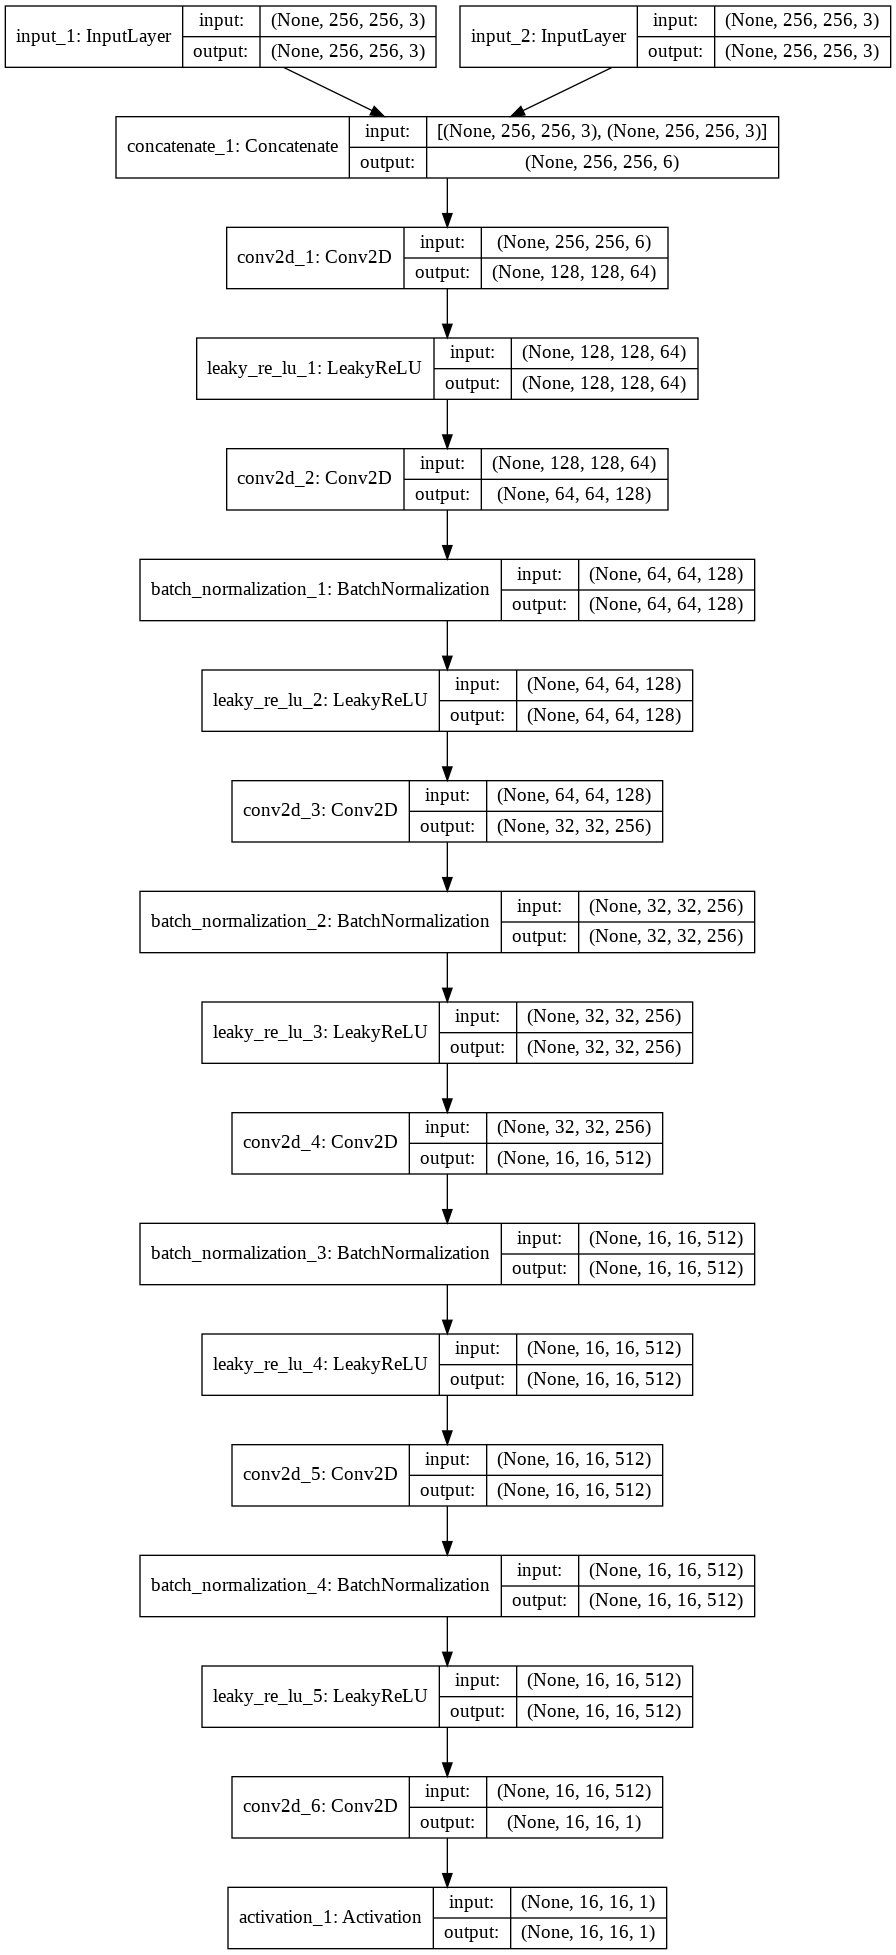

In [0]:
keras.utils.plot_model(d_model, show_shapes= True)

In [0]:
def encoder_unit(in_layer, n_filters, batch_norm = True):
  init = RandomNormal(0.02)
  g = Conv2D(n_filters, (4,4), strides = (2,2), kernel_initializer=init, padding = "same")(in_layer)
  if batch_norm:
    g = BatchNormalization()(g, training = True)
  g = LeakyReLU(0.2)(g)
  return g

In [0]:
def decoder_unit(in_layer, merge_layer, n_filters, dropout = True):
  init = RandomNormal(0.02)
  g = Conv2DTranspose(n_filters, (4,4), strides = (2,2), padding = "same", kernel_initializer=init)(in_layer)
  g = BatchNormalization()(g, training = True)
  if dropout:
    g = Dropout(0.5)(g)
  g = Concatenate()([g, merge_layer])
  g = Activation("relu")(g)

  return g

In [0]:
def generator(inp_shape = (256,256,3)):
  init = RandomNormal(0.02)
  in_img = Input(inp_shape)
  g1 = encoder_unit(in_img, 64, batch_norm = False)
  g2 = encoder_unit(g1, 128)
  g3 = encoder_unit(g2, 256) 
  g4 = encoder_unit(g3, 512)
  g5 = encoder_unit(g4, 512)
  g6 = encoder_unit(g5, 512)
  g7 = encoder_unit(g6, 512)

  bottleneck = Conv2D(512, (4,4), strides = (2,2), padding = "same", kernel_initializer=init)(g7)
  bottleneck = Activation("relu")(bottleneck)

  e1 = decoder_unit(bottleneck, g7, 512)
  e2 = decoder_unit(e1, g6, 512)
  e3 = decoder_unit(e2, g5, 512)
  e4 = decoder_unit(e3, g4, 512, dropout = False)
  e5 = decoder_unit(e4, g3, 256, dropout = False)
  e6 = decoder_unit(e5, g2, 128, dropout = False)
  e7 = decoder_unit(e6, g1, 64, dropout = False)

  patch = Conv2DTranspose(3, (4,4), strides = (2,2), padding = "same", kernel_initializer=init)(e7)
  patch_out = Activation("tanh")(patch)

  model = Model(in_img, patch_out)
  return model

In [0]:
g_model = generator()

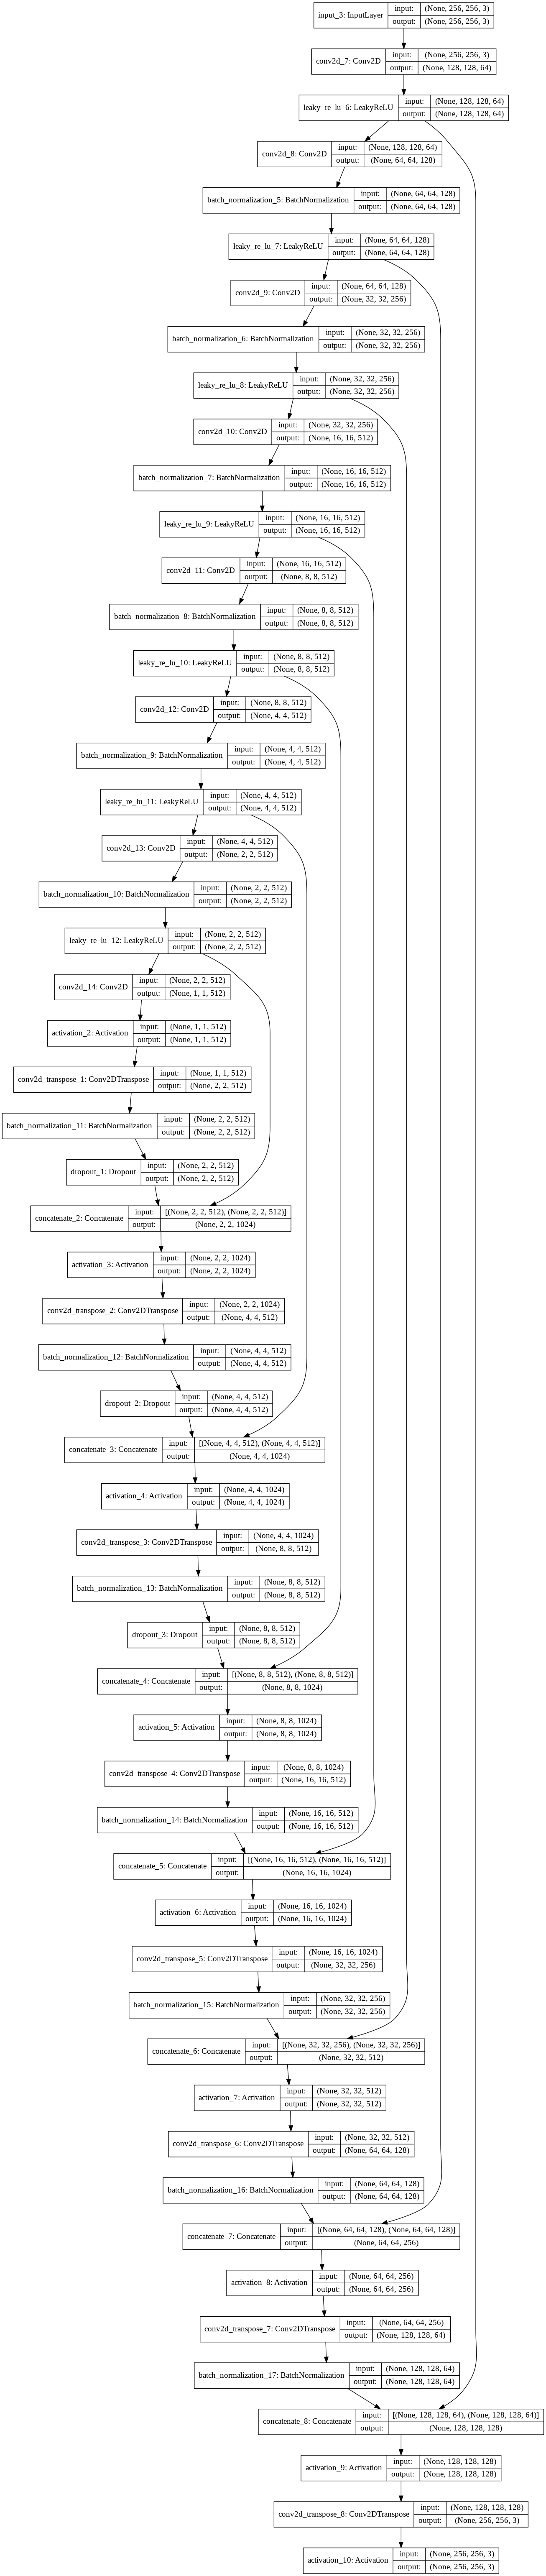

In [0]:
keras.utils.plot_model(g_model, show_shapes= True)

In [0]:
g_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_6[0][0]              
____________________________________________________________________________________________

In [0]:
def gan(d_model, g_model, inp_shape = (256,256,3)):
  d_model.trainable = False
  in_img = Input(inp_shape)
  g_out = g_model(in_img)
  d_out = d_model([in_img, g_out])
  model = Model(in_img, [d_out, g_out])
  model.compile(keras.optimizers.Adam(0.0002, 0.5), loss = ['binary_crossentropy', "mae"], loss_weights = [1,100])
  return model

In [0]:
gan_model = gan(d_model, g_model)

In [0]:
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 256, 256, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 16, 16, 1)    6968257     input_4[0][0]                    
                                                                 model_2[1][0]                    
Total params: 61,397,572
Trainable params: 54,419,459
Non-trainable params: 6,978,113
__________________________________________________________________________________________________


In [0]:
def generate_real_samples(data, batch_size, patch_size):
  src_imgs = data[0]
  tar_imgs = data[1]
  ind = np.random.randint(0, src_imgs.shape[0], batch_size)
  X_real, X_fake = src_imgs[ind], tar_imgs[ind]
  y = np.ones((batch_size, patch_size, patch_size, 1))
  return [X_real, X_fake], y

In [0]:
o = generate_real_samples(data, 2, 70)

In [0]:
o[0][0].shape

(2, 256, 256, 3)

In [0]:
def generate_fake_samples(g_model,samples, patch_size):
  pred = g_model.predict(samples)
  y = np.zeros((len(pred), patch_size, patch_size, 1))
  return pred, y

In [0]:
def summarize_performance(g_model, dataset,step, n_samples = 3):
  [X_real_src, X_real_tar], y_real = generate_real_samples(dataset, 3,1)
  X_fake_tar, _ = generate_fake_samples(g_model, X_real_src, 1)
  X_real_src = (X_real_src + 1) / 2.0
  X_real_tar = (X_real_tar + 1) / 2.0
  X_fake_tar = (X_fake_tar + 1) / 2.0
	# plot real source images
  plt.figure(figsize = (12,8))
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_real_src[i])
	# plot generated target image
  
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_fake_tar[i])
	# plot real target image
  
  for i in range(n_samples):
    plt.subplot(3, n_samples, 1 + n_samples*2 + i)
    plt.axis('off')
    plt.imshow(X_real_tar[i])
	# save plot to file
  filename1 = 'images/plot_%06d.png' % (step+1)
  plt.savefig(filename1)
  plt.close()
  # save the generator model
  filename2 = 'models/model_%06d.h5' % (step+1)
  g_model.save(filename2)

In [0]:
def train(d_model, g_model, gan_model, dataset, epochs = 100, batch_size = 1):
  steps = dataset[0].shape[0] * epochs
  patch_size = d_model.output_shape[1]
  for i in range(steps):
    [X_real_src, X_real_tar], y_real = generate_real_samples(dataset, batch_size, patch_size)
    X_fake, y_fake = generate_fake_samples(g_model, X_real_src, patch_size)
    d_loss1 = d_model.train_on_batch([X_real_src, X_real_tar], y_real)
    d_loss2 = d_model.train_on_batch([X_real_src, X_fake], y_fake)
    g_loss, _,_ = gan_model.train_on_batch(X_real_src, [y_real, X_real_tar])
    if((i+1)%500 == 0):
      print(">%d  d1 = [%.3f]  d2 = [%0.3f]  g = [%.3f]" % (i+1, d_loss1, d_loss2, g_loss))
    if((i+1)%1000 == 0):
      summarize_performance(g_model, dataset, i + 1)


In [0]:
train(d_model, g_model, gan_model, data)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>500  d1 = [0.398]  d2 = [0.345]  g = [8.995]
>1000  d1 = [0.360]  d2 = [0.372]  g = [22.071]
>1500  d1 = [0.373]  d2 = [0.383]  g = [10.761]
>2000  d1 = [0.380]  d2 = [0.380]  g = [11.107]
>2500  d1 = [0.360]  d2 = [0.388]  g = [18.848]
>3000  d1 = [0.359]  d2 = [0.367]  g = [7.049]
>3500  d1 = [0.360]  d2 = [0.369]  g = [11.585]
>4000  d1 = [0.383]  d2 = [0.378]  g = [9.404]
>4500  d1 = [0.480]  d2 = [0.329]  g = [14.141]
>5000  d1 = [0.191]  d2 = [1.085]  g = [9.399]
>5500  d1 = [0.362]  d2 = [0.533]  g = [20.751]
>6000  d1 = [0.251]  d2 = [0.206]  g = [8.429]
>6500  d1 = [0.162]  d2 = [0.135]  g = [8.448]
>7000  d1 = [0.380]  d2 = [0.091]  g = [10.106]
>7500  d1 = [0.028]  d2 = [0.050]  g = [12.932]
>8000  d1 = [0.119]  d2 = [0.130]  g = [10.218]
>8500  d1 = [0.037]  d2 = [0.196]  g = [9.349]
>9000  d1 = [0.185]  d2 = [0.052]  g = [9.283]
>9500  d1 = [0.023]  d2 = [0.334]  g = [17.260]
>10000  d1 = [0.038]  d2 = [0.031]  g = [17.545]
>10500  d1 = [0.036]  d2 = [0.198]  g = [9.438]
